In [1]:
import os

import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns
dataset_dir = "../dataset/"

## Analyse exploratoire des données

### Clicks

In [2]:
clicks_df = pd.DataFrame()
for file in os.listdir('dataset/clicks'):
    tmp = pd.read_csv('dataset/clicks/' + file)
    if clicks_df.empty:
        clicks_df = tmp
    else:
        clicks_df = pd.concat([clicks_df, tmp])
clicks_df = clicks_df.drop_duplicates()

print("clicks_df shape:", clicks_df.shape)
print("Unique users:", clicks_df['user_id'].nunique())
print("Unique articles:", clicks_df['click_article_id'].nunique())

print("\nclicks_df df:")
clicks_df.describe()

clicks_df shape: (2988181, 12)
Unique users: 322897
Unique articles: 46033

clicks_df df:


,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
count,2988181,2988181,2988181,2988181,2988181,2988181,2988181,2988181,2988181,2988181,2988181,2988181
unique,322897,1048594,646874,72,46033,2983198,3,5,8,11,28,7
top,5890,1507563657895091,1507563657000,2,160974,1506961009961,4,1,17,1,25,2
freq,1232,124,127,1260372,37213,3,2904478,1823162,1738138,2852406,804985,1602601


             user_id  unique_clicks
count  322897.000000  322897.000000
mean   161448.000000       9.138239
std     93212.479273      14.344677
min         0.000000       2.000000
25%     80724.000000       2.000000
50%    161448.000000       4.000000
75%    242172.000000      10.000000
max    322896.000000    1048.000000


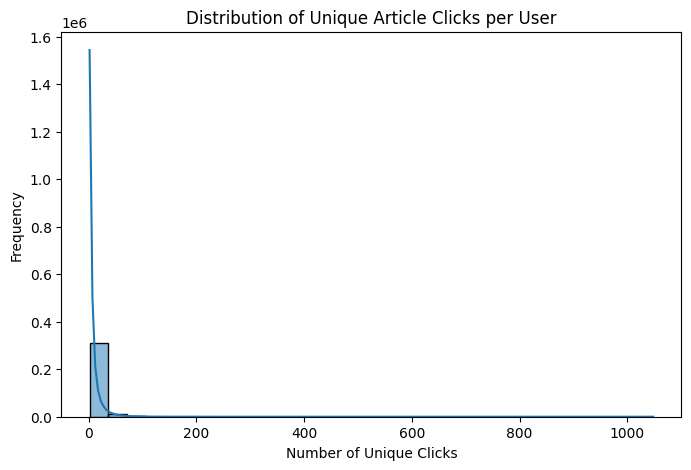

In [3]:
clicks_per_user = (
    clicks_df.groupby('user_id')['click_article_id']
    .nunique()
    .reset_index(name='unique_clicks')  # converts Series → DataFrame
    .sort_values(by='unique_clicks', ascending=False)
)

print(clicks_per_user.describe())
# Plot Gaussian-like distribution
plt.figure(figsize=(8, 5))
sns.histplot(clicks_per_user['unique_clicks'], bins=30, kde=True) # type: ignore
plt.title('Distribution of Unique Article Clicks per User')
plt.xlabel('Number of Unique Clicks')
plt.ylabel('Frequency')
plt.show()

In [5]:
clicks_per_user.loc[clicks_per_user['user_id'] < 706].head()

,user_id,unique_clicks
169,169,417
64,64,274
681,681,267
94,94,237
413,413,202


### Articles
Nous ne conserverons que les articles présents dans le registre des intéractions (clicks_df)

In [ ]:
articles_df = pd.read_csv('dataset/articles_metadata.csv')
print("DF shape (before filtering):", articles_df.shape)
print("Number of unique articles (before filtering): ", articles_df['article_id'].nunique())
print("Number of unique article categories (before filtering): ", articles_df['category_id'].nunique())

print("\n===============================\nArticles metadata DataFrame:")
print(f"Features: {articles_df.columns}")
articles_df.head(1)

articles_df = articles_df.loc[articles_df['article_id'].isin(clicks_df['click_article_id'])]
print("DF shape (after filtering):", articles_df.shape)
print("Number of unique articles (after filtering): ", articles_df['article_id'].nunique())
print("Number of unique article categories (after filtering): ", articles_df['category_id'].nunique())
articles_df.describe()

DF shape (before filtering): (364047, 4)
Number of unique articles (before filtering):  364047
Number of unique article categories (before filtering):  461

Articles metadata DataFrame:
Features: Index(['article_id', 'category_id', 'created_at_ts', 'words_count'], dtype='object')
DF shape (after filtering): (46033, 4)
Number of unique articles (after filtering):  46033
Number of unique article categories (after filtering):  316


,article_id,category_id,created_at_ts,words_count
count,46033.000000,46033.000000,4.603300e+04,46033.000000
mean,173974.753286,274.092412,1.480919e+12,191.416897
std,103198.968039,134.853955,3.632288e+10,75.443807
min,3.000000,1.000000,1.166573e+12,0.000000
25%,83525.000000,174.000000,1.464704e+12,158.000000
50%,167166.000000,290.000000,1.499864e+12,187.000000
75%,264671.000000,398.000000,1.507016e+12,219.000000
max,364046.000000,460.000000,1.510666e+12,6690.000000


## Moteur de recommendation basé sur le contenu

In [10]:
embeddings_file = 'models/articles_embeddings.pkl'
embeddings = pd.read_pickle(embeddings_file)
print("embeddings.shape:", embeddings.shape)

embeddings.shape: (364047, 250)


Des *embeddings* pré-calculés *(articles_embeddings.pickle)* nous sont fournis. Ceux-ci corespondent à au fichier *articles_metadata.csv*. Il n'est donc pas utile dans le cadre de ce projet de recalculer des *embeddings*. Il nous suffira ici de concevoir un modèle exploitant ce fichier.

Il convient de ne sélecionner que les articles qui seront présents *in-fine* dans notre base de données :

In [ ]:
# Normalize embeddings once for cosine similarity via dot product
available_articles = articles_df['article_id'].drop_duplicates().to_list()
print(len(available_articles))

embeddings = embeddings[available_articles]

# Tables de correspondance index <-> id de l'article
available_articles = np.array(available_articles)
article_ids_to_index = {aid: idx for idx, aid in enumerate(available_articles)}

46033


#### Choix de la mesure

**Choix de la mesure :**
Tout le travail de conception de l'algorithme se résume à utiliser le calcul de distance le plus adapté. Nous pourrons tester :
- *cosine* (méthode standard);
- *euclidian* (L2) ;
- *dot product* ;
- *Manhattan distance* (L1).

In [12]:
from sklearn.preprocessing import normalize
embeddings_norm = normalize(embeddings, axis=1)

def recommend_cosine(article_id: int, n_recs=None):
    if article_id not in available_articles:
        print("Provided article is not available.")
        return None
    article_idx = article_ids_to_index[article_id]
    q = embeddings_norm[article_idx]
    q = q / np.linalg.norm(q)  # normalize query
    sims = embeddings_norm @ q  # assuming embeddings pre-normalized

    # Optional: map cosine [-1,1] → [0,1]
    sims = (sims + 1) / 2

    sorted_idx = np.argsort(-sims)
    sorted_idx = [i for i in sorted_idx if i != article_idx]

    if n_recs is not None:
        top_idx = sorted_idx[:n_recs]
        top_scores = sims[top_idx]
        recs = list(zip(available_articles[top_idx], top_scores)) # type: ignore
    else:
        recs = list(zip(available_articles, sims))
    return recs


def recommend_euclidean(article_id: int, n_recs=None):
    if article_id not in available_articles:
        return None
    
    article_idx = article_ids_to_index[article_id]
    q = embeddings[article_idx]
    dists = np.linalg.norm(embeddings - q, axis=1)
    
    # convertir en score de similarité inversé
    sims = 1 / (1 + dists)

    sorted_idx = np.argsort(-sims)
    sorted_idx = [i for i in sorted_idx if i != article_idx]

    if n_recs:
        top_idx = sorted_idx[:n_recs]
        return list(zip(available_articles[top_idx], sims[top_idx])) # type: ignore
    return list(zip(available_articles, sims))


def recommend_dot(article_id: int, n_recs=None):
    if article_id not in available_articles:
        return None
    
    article_idx = article_ids_to_index[article_id]
    q = embeddings[article_idx]
    sims = embeddings @ q

    sorted_idx = np.argsort(-sims)
    sorted_idx = [i for i in sorted_idx if i != article_idx]

    if n_recs:
        top_idx = sorted_idx[:n_recs]
        return list(zip(available_articles[top_idx], sims[top_idx])) # type: ignore
    return list(zip(available_articles, sims))


def recommend_manhattan(article_id: int, n_recs=None):
    if article_id not in available_articles:
        return None
    
    article_idx = article_ids_to_index[article_id]
    q = embeddings[article_idx]
    dists = np.sum(np.abs(embeddings - q), axis=1)
    sims = 1 / (1 + dists)

    sorted_idx = np.argsort(-sims)
    sorted_idx = [i for i in sorted_idx if i != article_idx]

    if n_recs:
        top_idx = sorted_idx[:n_recs]
        return list(zip(available_articles[top_idx], sims[top_idx])) # type: ignore
    return list(zip(available_articles, sims))


print("Cosine:", recommend_cosine(4658, 5))
print("Euclidean:", recommend_euclidean(4658, 5))
print("Dot:", recommend_dot(4658, 5))
print("Manhattan", recommend_manhattan(4658, 5))

Cosine: [(5143, 0.934284), (5054, 0.93288666), (4909, 0.926558), (4708, 0.9218701), (3828, 0.92167604)]
Euclidean: [(5143, 0.19366434), (5054, 0.19146499), (4909, 0.1778421), (5252, 0.17327572), (5033, 0.17015295)]
Dot: [(4706, 64.5034), (3828, 63.768658), (4708, 63.0218), (5033, 62.53337), (5013, 62.117054)]
Manhattan [(5054, 0.019330956), (5143, 0.018745584), (4909, 0.017367946), (5254, 0.017163934), (5252, 0.01692573)]


#### Stratégie de recommendation - content based

***Plusieurs possibilités s'offrent à nous:***
- Proposer des recommendations en fonction d'un ou plusieurs articles parmis les derniers cliqués ;
- Proposer des recommendations en fonction d'un article passé explicitement en argument (ex: lorsquel l'utilisateur est sur la page d'un produit / qu'il semble rechercher direcement un article en particulier).

## Modèle de collaborative filtering

### Technologie utilisée
Nous utiliserons la librairie Surprise. Celle-ci fonctionne grace à des triplets [utilisateur, article, rating]. Il convient donc calculer ces ratings :

In [ ]:
# click_stats = clicks_df.copy()
click_stats = pd.read_csv('dataset/clicks_sample.csv')
click_stats['click_time'] = pd.to_datetime(click_stats['click_timestamp'], unit='ms')

max_time = click_stats['click_time'].max()
click_stats["click_days_ago"] = (max_time - click_stats['click_time']).dt.days
click_stats["recency_weight"] = 1 / (1 + click_stats["click_days_ago"]) # Les clicks les plus récents ont plus de poids

click_stats = click_stats.rename(columns={'click_article_id': 'article_id'})

click_stats = (
        click_stats.drop(columns=['click_timestamp'])
        .groupby(['user_id', 'article_id'])
        .agg(click_count=('article_id', 'count'),
             recency_weight=('recency_weight', 'sum'))
        .reset_index()
)

click_stats["interaction_weight"] = (
    click_stats["click_count"] ** 0.75 + click_stats["recency_weight"] * 3
)  # Un article est plus pertinent si l'utilisateur a cliqué plusieurs fois dessus et si le click est récent
strength = np.log1p(click_stats['interaction_weight'])  ** 1.2 # Smoothing

# Rank-normalize to [1, 5]
ranks = strength.rank(pct=True) # type: ignore
ratings = 1 + 4 * ranks

rating_triplets = (
    click_stats.assign(rating=ratings)
    .rename(columns={"article_id": "item_id"})
    [["user_id", "item_id", "rating"]]
)
rating_triplets.describe()

,user_id,item_id,rating
count,1883.000000,1883.000000,1883.000000
mean,355.893787,176717.848646,3.001062
std,206.162865,82324.177259,0.102950
min,0.000000,2137.000000,2.995751
25%,181.500000,108854.000000,2.995751
50%,353.000000,157541.000000,2.995751
75%,537.000000,236697.500000,2.995751
max,706.000000,363291.000000,4.995751


In [ ]:
from surprise import Dataset, Reader, SVDpp

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(rating_triplets, reader)
trainset = data.build_full_trainset()

model = SVDpp(
    n_factors=100,     # dimensionality of latent vectors
    n_epochs=20,       # training passes over data
    lr_all=0.004,      # learning rate for all biases and factors
    reg_all=0.04,      # regularization (slightly higher for implicit data)
    random_state=42
)
model.fit(trainset)

# Save model and user/item mappings
artifact = {
    "model": model,
    "user_raw_to_inner": trainset._raw2inner_id_users,
    "item_raw_to_inner": trainset._raw2inner_id_items,
    "user_inner_to_raw": trainset._inner2raw_id_users,
    "item_inner_to_raw": trainset._inner2raw_id_items,
}

In [ ]:
def recommend_for_user( user_id, candidates, N=None):
    known_candidates = []
    for iid in candidates:
        try:
            _ = model.trainset.to_inner_iid(iid)  # check existence
            known_candidates.append(iid)
        except ValueError:
            continue  # item not in model; skip it

    if not known_candidates:
        return []
    # Compute predicted ratings for candidate items
    preds = [(iid, model.predict(user_id, iid).est) for iid in known_candidates]

    # Extract scores and normalize them to [0, 1]
    scores = np.array([p[1] for p in preds])
    if len(scores) == 0:
        return []

    min_s, max_s = scores.min(), scores.max()
    if max_s > min_s:
        norm_scores = (scores - min_s) / (max_s - min_s)
    else:
        norm_scores = np.zeros_like(scores)
    # Combine normalized scores with item IDs
    scored = list(zip([iid for iid, _ in preds], norm_scores))
    # Sort by normalized score descending and take top N
    scored.sort(key=lambda x: x[1], reverse=True)
    return scored[:N] if N is not None else scored


print("SVDpp recs:", recommend_for_user(76, available_articles, 5))

#### Utilisation de Implicit

In [ ]:
import implicit
from scipy.sparse import csr_matrix

# Map IDs to contiguous integers (implicit requires 0..N-1 indices)
interactions = click_stats[['user_id', 'article_id', 'interaction_weight']]
user_mapping = {uid: i for i, uid in enumerate(interactions["user_id"].unique())}
item_mapping = {aid: i for i, aid in enumerate(interactions["article_id"].unique())}

interactions["user_idx"] = interactions["user_id"].map(user_mapping)
interactions["item_idx"] = interactions["article_id"].map(item_mapping)

# Build sparse user-item matrix
user_item_matrix = csr_matrix(
    (interactions["interaction_weight"],
    (interactions["user_idx"], interactions["item_idx"]))
)


# Initialize model (you can tune factors, regularization, iterations)
model = implicit.als.AlternatingLeastSquares(
    factors=64,
    regularization=0.1,
    iterations=20
)

# Fit the model
# implicit expects item-user matrix for training
model.fit(user_item_matrix.T)

# Pick a user_id
user_id = 76
user_idx = user_mapping[user_id]

# Recommend top 10 articles
items, scores = model.recommend(user_idx, user_item_matrix[user_idx], N=10)
for item, score in zip(items, scores):
    print(f"Item: {item}, score: {score}")